In [1]:
import numpy as np
import pandas as pd
from dask.distributed import Client
import webbrowser
from sm_particle_counter.utils import *
from dask_image import imread
from os.path import basename, splitext, exists
from time import sleep
from os import listdir
from pims.api import UnknownFormatError
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import maximum_filter

In [2]:
client = Client()
webbrowser.open(client.dashboard_link);

# Particle counting

In [71]:
def segment_particles(layer, threshold):
    """
    Threshold the image to select bright particles and apply maximum filter
    to erode background around them, leaving only a single white pixel per
    particle.
    """
    masked_layer = layer * (layer > threshold)
    return maximum_filter(layer, size=3) == masked_layer


def count_particles(stack):
    """
    Count particles in each spectral channel of a TIFF stack. Each channel
    is segmented with an individual threshold computed based on the first frame.
    Returns a pandas data frame with columns representing spectral channels
    """
    thresh = dict()
    for channel, img in get_channels(stack[1]).items():
        # Threshold calculation
        bg, q25, q75 = np.quantile(img.compute(), [0.05, 0.25, 0.75])
        iqr = q75 - q25
        thresh[channel] = bg + 5 * iqr

    # Create an image containing threshold values to compare with
    thresh_img = np.ones_like(stack[0]) * thresh['Cy3']
    if n_channels(thresh_img) == 2:
        thresh_img[Cy5(thresh_img)] = thresh['Cy5']

    # Create a stack containing one white pixel per each detected particle
    segmented_stack = stack.map_blocks(segment_particles, threshold=thresh_img)

    # Use dask to flatten the stack vertically. Each new element represents number
    # of particles in a specific vertical column of pixels. Creates numpy array.
    flattened_stack = segmented_stack.sum(axis=-2).compute()

    n_particles = dict()
    for channel, subset in get_channels(flattened_stack).items():
        n_particles[channel] = subset.sum(axis=-1)

    return pd.DataFrame.from_dict(n_particles)


def tiff_count_particles(tiff_file, csv_file):
    """
    Count particles in each spectral channel of a TIFF file.
    Saves result in a CSV file.
    """
    stack = imread.imread(tiff_file)[1:]  # drop first frame, it's usually garbage
    df = count_particles(stack)
    df.to_csv(csv_file)

def cond_run(infile, suffix, action):
    """
    Run `action` on input file `infile`. `action` creates an output file.
    The output file name is created by dropping extension of `infile` and adding `suffix`.
    Skip `action` if output file exists. Essentially, it caches the `action` result.
    """
    outfile = splitext(infile)[0] + suffix
    if not exists(outfile):
        return action(infile, outfile)
    else:
        print(f"Skipping {infile} because {outfile} exists.")

def plot_csv(csv_file, png_file):
    df = pd.read_csv(csv_file, index_col=0)
    for channel, Y in df.items():
        plt.plot(Y, label = channel)
    plt.legend()
    plt.title(basename(csv_file))
    plt.grid('both', color="#e6e6e6", lw=0.25)
    plt.savefig(png_file, dpi=600)
    #plt.close()
    plt.show()


Skipping D:/2023-06 injection test data/test_070.tif because D:/2023-06 injection test data/test_070_particles.csv exists.


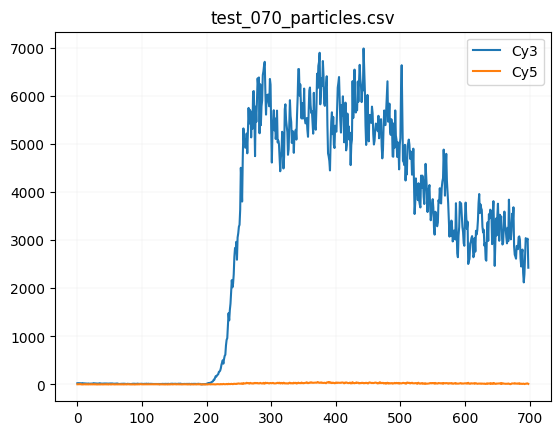

In [73]:
# Test run on a TIFF file
fn = "D:/2023-06 injection test data/test_070.tif"
cond_run(fn, "_particles.csv", tiff_count_particles)

# Test run on a CSV file
fn = splitext(fn)[0] + "_particles.csv"
df = cond_run(fn, ".png", plot_csv)

# Intensity analysis

In [57]:
 def analyze_intensity(stack):
    """
    Count particles in each spectral channel of a TIFF stack. Each channel
    is segmented with an individual threshold computed based on the first frame.
    Returns a pandas data frame with columns representing spectral channels
    """

    # Use dask to flatten image vertically, replacing each column with its average value
    flattened_stack = stack.mean(axis = -2).compute()

    channel_intensity = {}
    # Compute mean value across all the columns in a frame, per spectral channel
    for channel, subset in get_channels(flattened_stack).items():
        channel_intensity[channel] = subset.mean(axis=-1)

    return pd.DataFrame.from_dict(channel_intensity)


def tiff_analyze_intensity(tiff_file, csv_file):
    """
    Measure average intensity of each frame in each spectral channel of a TIFF file.
    Saves result in a CSV file.
    """
    stack = imread.imread(tiff_file)[1:]  # drop first frame, it's usually garbage
    df = analyze_intensity(stack)
    df.to_csv(csv_file)

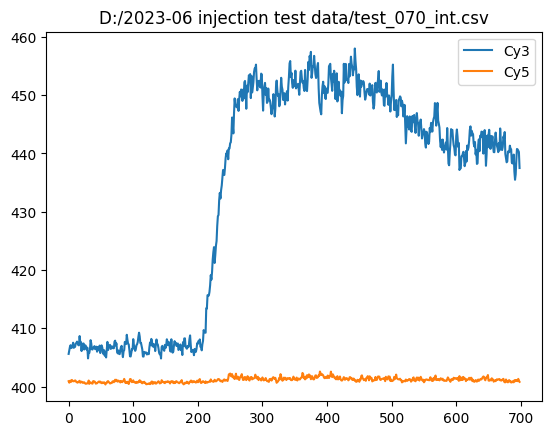

In [58]:
# Test run on a TIFF file
fn = "D:/2023-06 injection test data/test_070.tif"
cond_run(fn, "_int.csv", tiff_analyze_intensity)

# Test run on a CSV file
fn = splitext(fn)[0] + "_int.csv"
df = cond_run(fn, ".png", plot_csv)

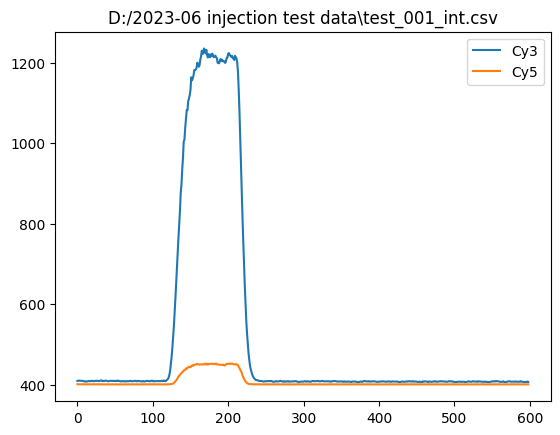

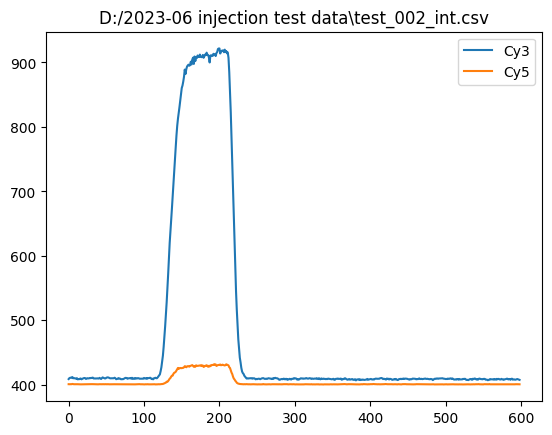

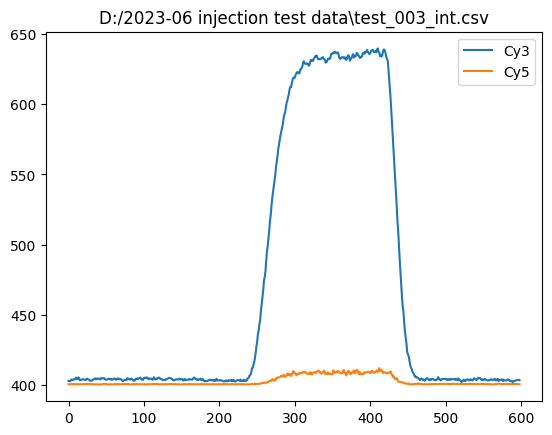

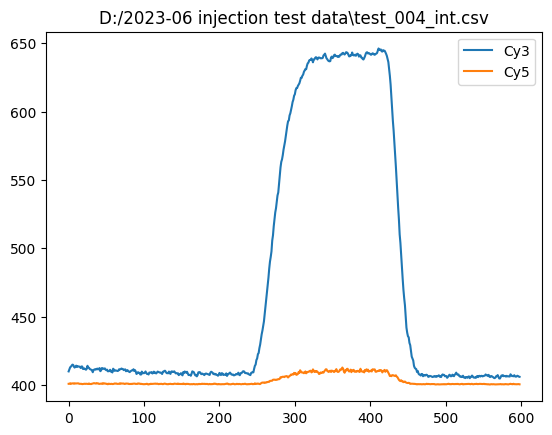

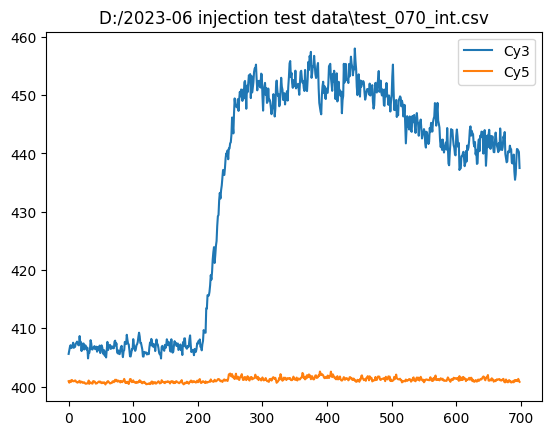

In [63]:
from os.path import join
dir = "D:/2023-06 injection test data"
for fn in listdir(dir):
    fn = join(dir, fn)
    try:
        cond_run(fn, "_int.csv", tiff_analyze_intensity)
        fn = splitext(fn)[0] + "_int.csv"
        df = cond_run(fn, ".png", plot_csv)
    except:
        pass

In [62]:
fn

'test_070.tif'